# Preprocesamiento de datos 

In [2]:

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns



# Preprocesamiento
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import OrdinalEncoder
import math
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer


#Linear Regresion con Sklearn
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics




# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


# Tamaño gráficas
# ==============================================================================
plt.rcParams["figure.figsize"] = (10,8)

## Enunciado 
Trabajamos para una compañia de seguros, nuestro jefe tiene unos datos sobre el dinero que gastan en una serie de clientes basándose en una serie de características, estas son:

1. **age**: Esta columna representa la edad de la persona a la que se refiere la entrada en el DataFrame. Por ejemplo, en la primera fila, la persona tiene 19 años.

2. **sex**: En esta columna, se indica el género o sexo de la persona. Puede tener dos posibles valores: "female" (femenino) o "male" (masculino). Por ejemplo, en la primera fila, la persona es de sexo femenino.

3. **bmi**: Esta columna se refiere al Índice de Masa Corporal (BMI, por sus siglas en inglés) de la persona. El BMI es una medida que relaciona el peso y la altura de una persona y se utiliza para evaluar su nivel de obesidad o peso saludable. Por ejemplo, en la primera fila, el BMI es 27.900.

4. **children**: Aquí se indica la cantidad de hijos o dependientes que tiene la persona. Puede ser un número entero. Por ejemplo, en la primera fila, la persona no tiene hijos (valor 0).

5. **smoker**: Esta columna indica si la persona es fumadora o no. Puede tener dos posibles valores: "yes" (sí) si es fumadora y "no" si no lo es. Por ejemplo, en la primera fila, la persona es fumadora.

6. **region**: En esta columna se especifica la región geográfica en la que reside la persona. Puede tomar varios valores que representan diferentes regiones geográficas. Por ejemplo, en la primera fila, la persona reside en la región "southwest" (suroeste).

7. **charges**: Esta columna se refiere a los cargos o costos médicos asociados a la persona. Los cargos médicos pueden incluir los gastos de atención médica y seguro de salud. Por ejemplo, en la primera fila, los cargos médicos son de 16884.92400.

Nuestro objetivo hacer un modelo de machine learning que nos permita predecir cuanto nos vamos a gastar en futuros clientes para decidir si les aceptamos como clientes o no. 


In [5]:
df = pd.read_csv("data/insurance.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,NaN,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,NaN,NaN,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


# Análisis exploratorio

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1204 non-null   float64
 1   sex       1151 non-null   object 
 2   bmi       1325 non-null   float64
 3   children  1231 non-null   float64
 4   smoker    1057 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 83.6+ KB


### Clasificacion de variables por tipo
- Variable Respuesta (VR): `charges` de tipo numerico
- Variables Predictoras (VP): 
    - Variables de tipo numericas: `age`, `bmi` , `children`.
    - Variables categoricas:  `sex`, `smoker`, `region`
        

### Deteccion de nulos 

In [7]:
df.isnull().sum()

age         134
sex         187
bmi          13
children    107
smoker      281
region        1
charges       0
dtype: int64

### Deteccion de duplicados 

In [8]:
df.duplicated().sum()

0

## Analisis de la Variable Respuesta


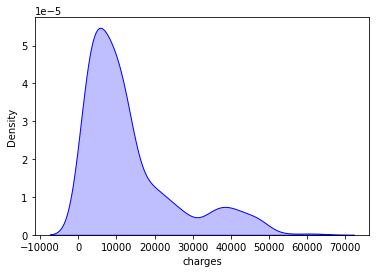

In [9]:

sns.distplot(
    df["charges"], 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

In [10]:
stats.shapiro(df["charges"])

ShapiroResult(statistic=0.8146880269050598, pvalue=1.150477698013898e-36)

- El test de shapiro indica que la Variable Respuesta no es normal por lo que tendremos que intentar **Normalizarla** .

## Variables prdictoras


In [11]:
# exploramos cuáles son los principales estadísticos de las variables numéricas

df.select_dtypes(include = np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
age,1204.0,39.165282,14.109891,18.0000,26.00000,39.000,51.000000,64.00000
bmi,1325.0,30.648317,6.069316,15.9600,26.29000,30.400,34.600000,53.13000
children,1231.0,1.099919,1.209283,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


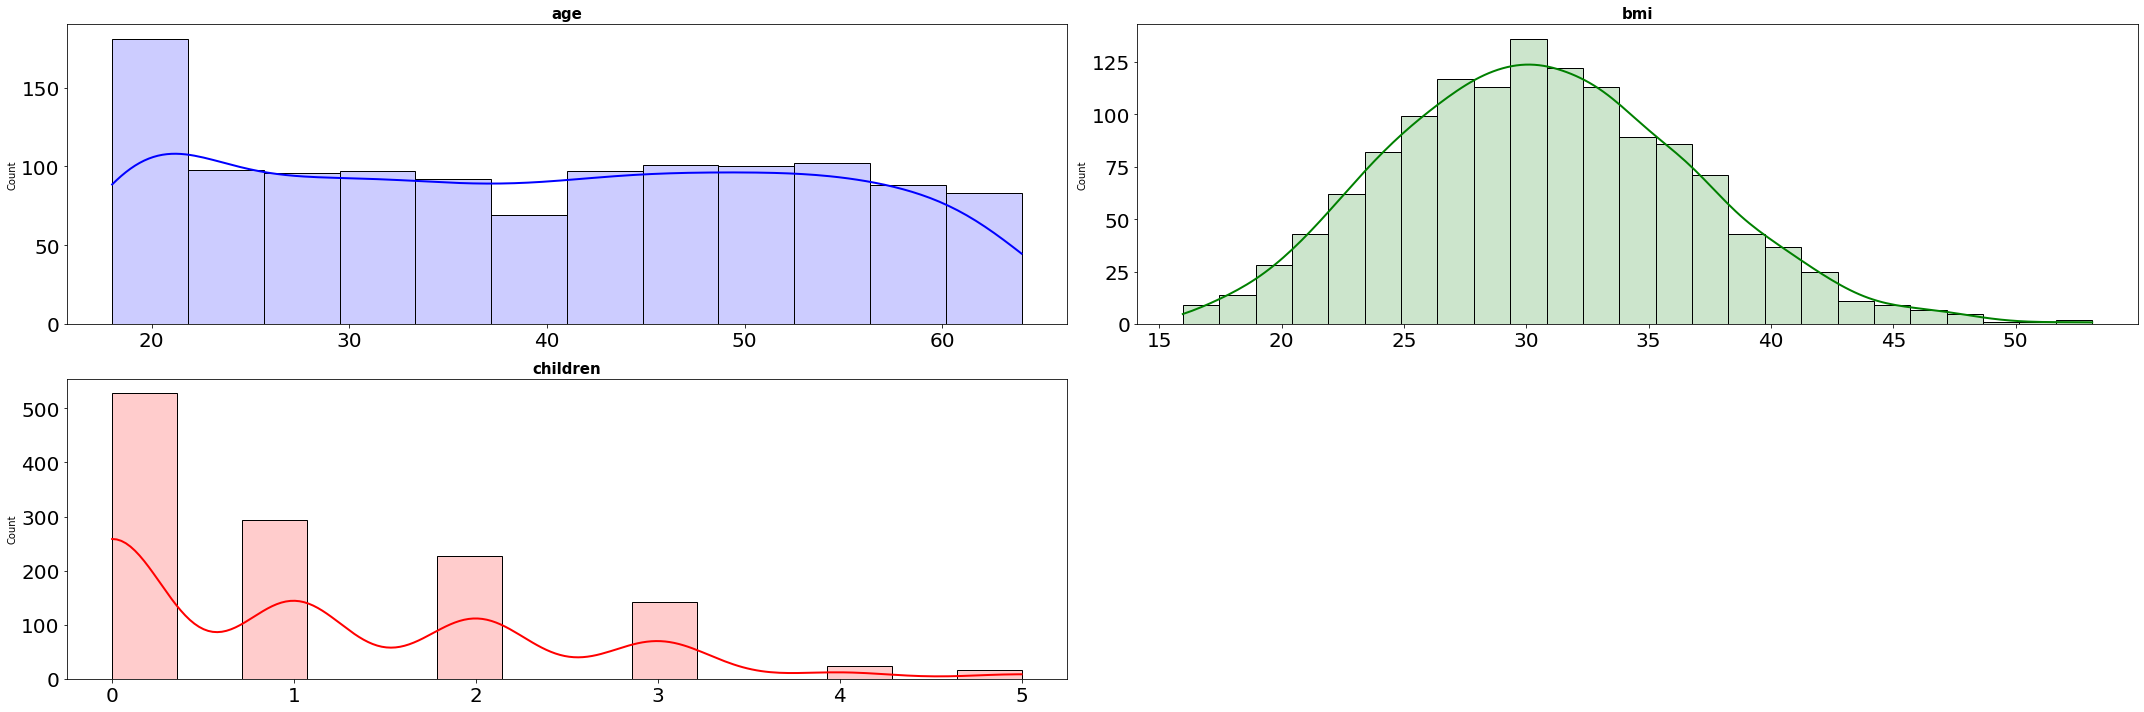

In [17]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))

lista_colores = ["blue", "green", "red"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = lista_colores[i], 
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    

fig.tight_layout()
fig.delaxes(axes[-1]) # Eliminamos el último eje que no se usa;
    



- Parece que la variable `bmi` se comporta como una normal 

In [18]:
stats.shapiro(df["bmi"])

ShapiroResult(statistic=nan, pvalue=1.0)

In [22]:
stats.shapiro(df["children"])

ShapiroResult(statistic=nan, pvalue=1.0)

In [24]:
stats.shapiro(df["age"])

ShapiroResult(statistic=nan, pvalue=1.0)

- Parece que todas las variables numericas son normales

Confirmamos que la variable `bmi` se comporta como una normal

## Relacion de Variable Rerspuesta con las Varaibles Predictoras


###  VR vs VP Numericas 

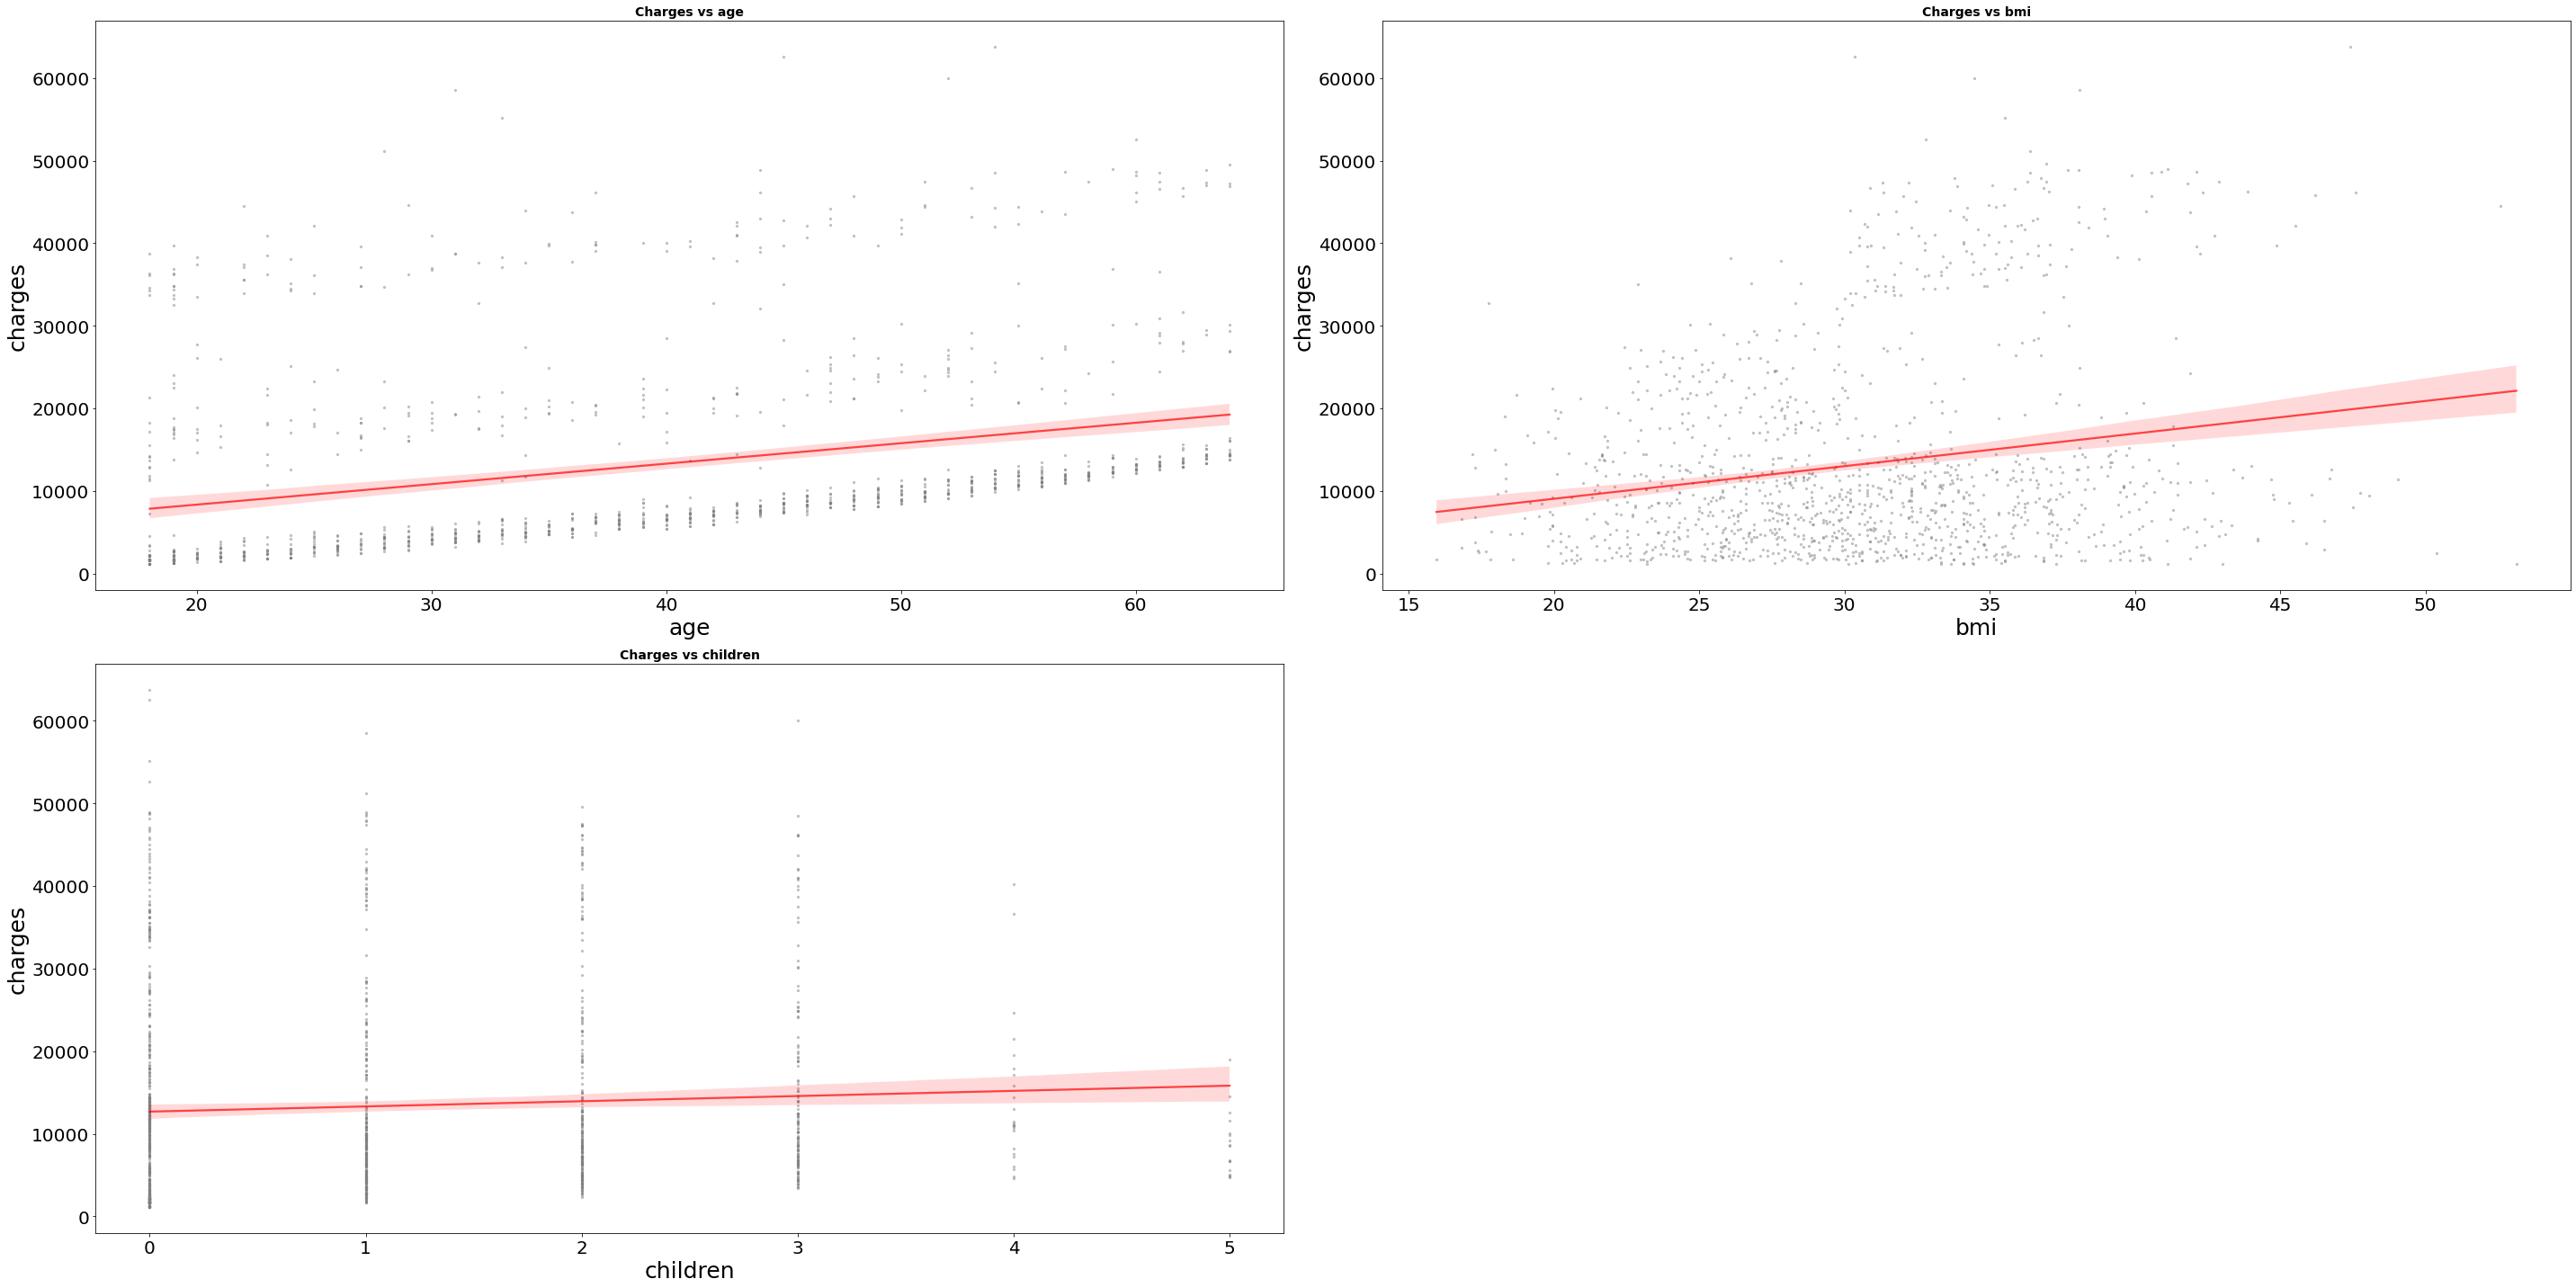

In [19]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["charges"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4, "s":20 }, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Charges vs {colum}", fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum, fontsize = 25)
    axes[i].set_ylabel( "charges", fontsize = 25)
    
fig.tight_layout()
fig.delaxes(axes[-1]);

- La variable children podria ser categorica 


In [25]:
df["children"] = df["children"].astype("category")

In [26]:
df.dtypes

age          float64
sex           object
bmi          float64
children    category
smoker        object
region        object
charges      float64
dtype: object

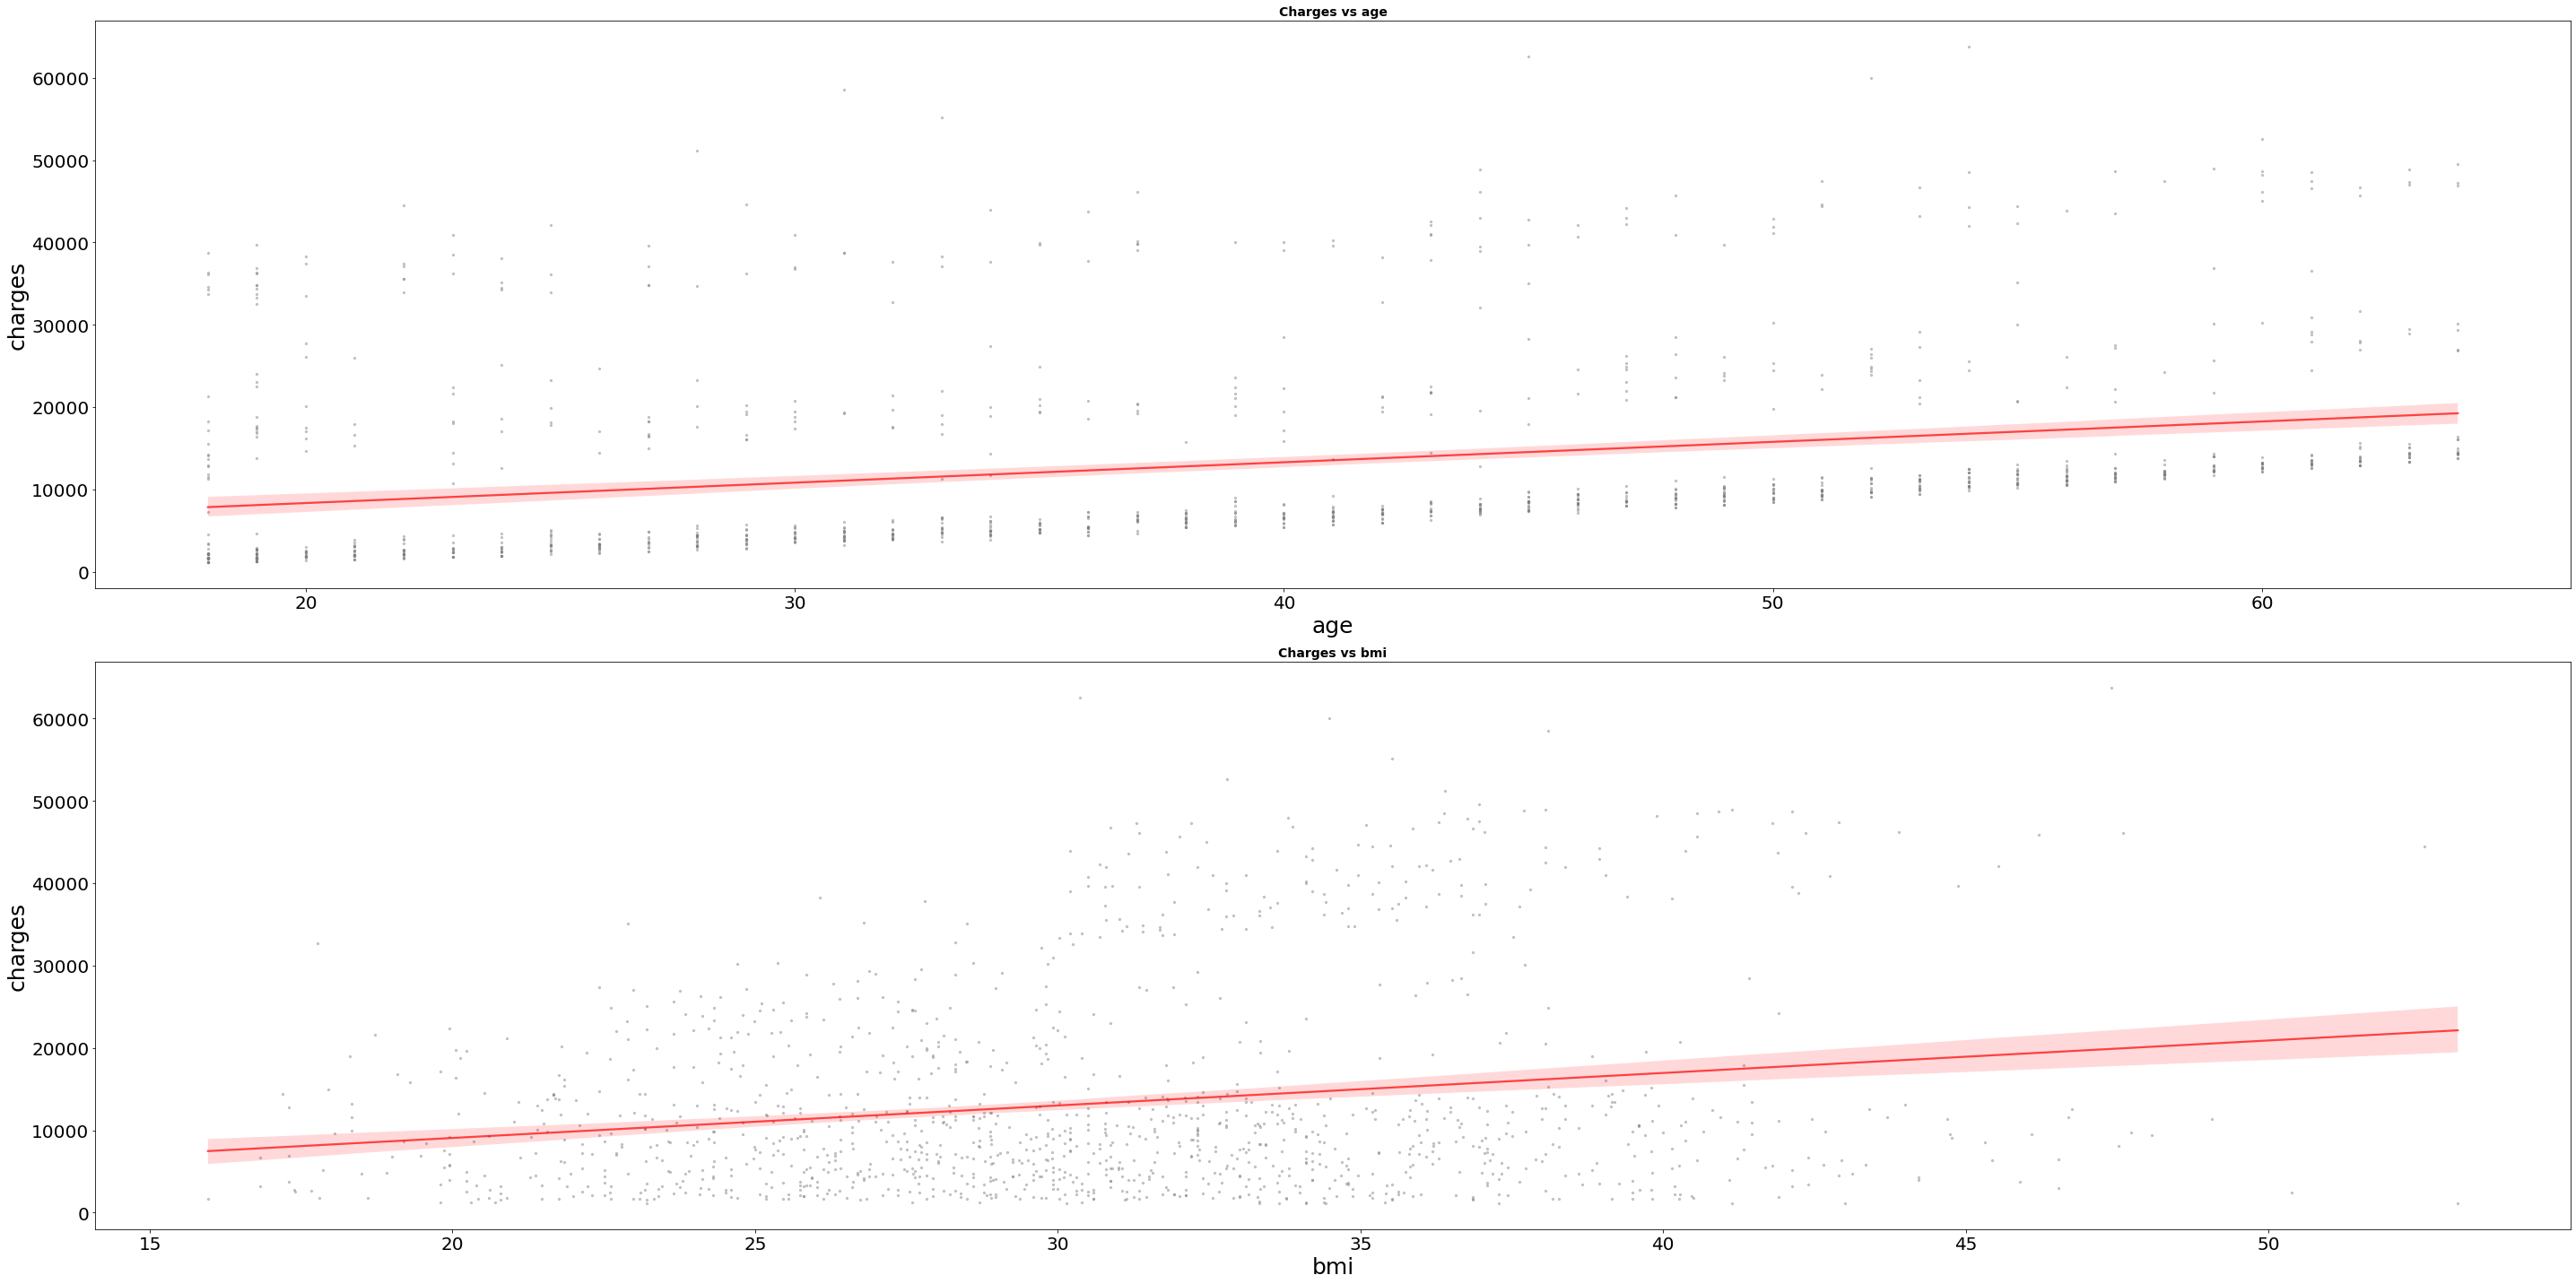

In [27]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (40, 20))

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["charges"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4, "s":20 }, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Charges vs {colum}", fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum, fontsize = 25)
    axes[i].set_ylabel( "charges", fontsize = 25)
    
fig.tight_layout();

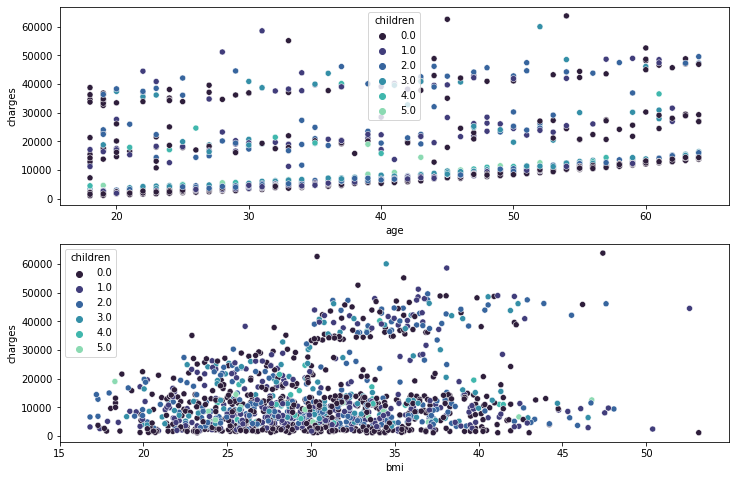

In [33]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8))
sns.scatterplot(x = "age", y = "charges", hue = "children", data = df, palette="mako", ax = axes[0])
sns.scatterplot(x = "bmi", y = "charges", hue = "children", data = df, palette="mako", ax = axes[1]);

- Parece que o existe nigun patron con el gasto de aseguradoras

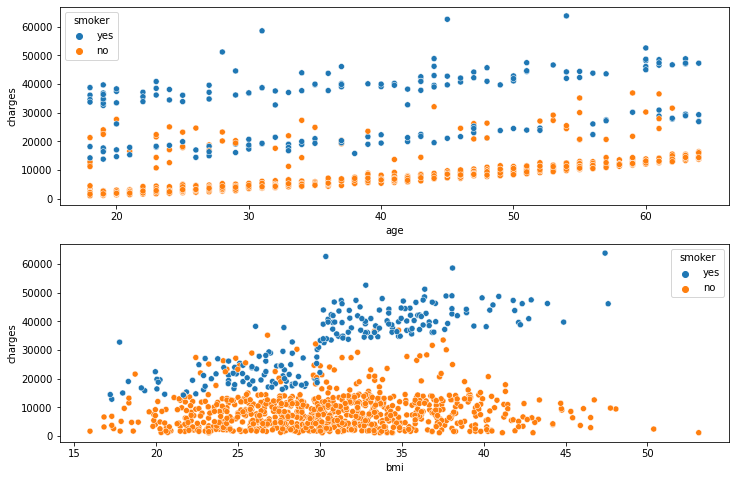

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8))
sns.scatterplot(x = "age", y = "charges", hue = "smoker", data = df,  ax = axes[0])
sns.scatterplot(x = "bmi", y = "charges", hue = "smoker", data = df,  ax = axes[1]);

- Se observa como los no fumadores pagan menos 

## Variables predictoras 
nos ayudara a decidir si nuestras variables categoricas tienen o no orden 

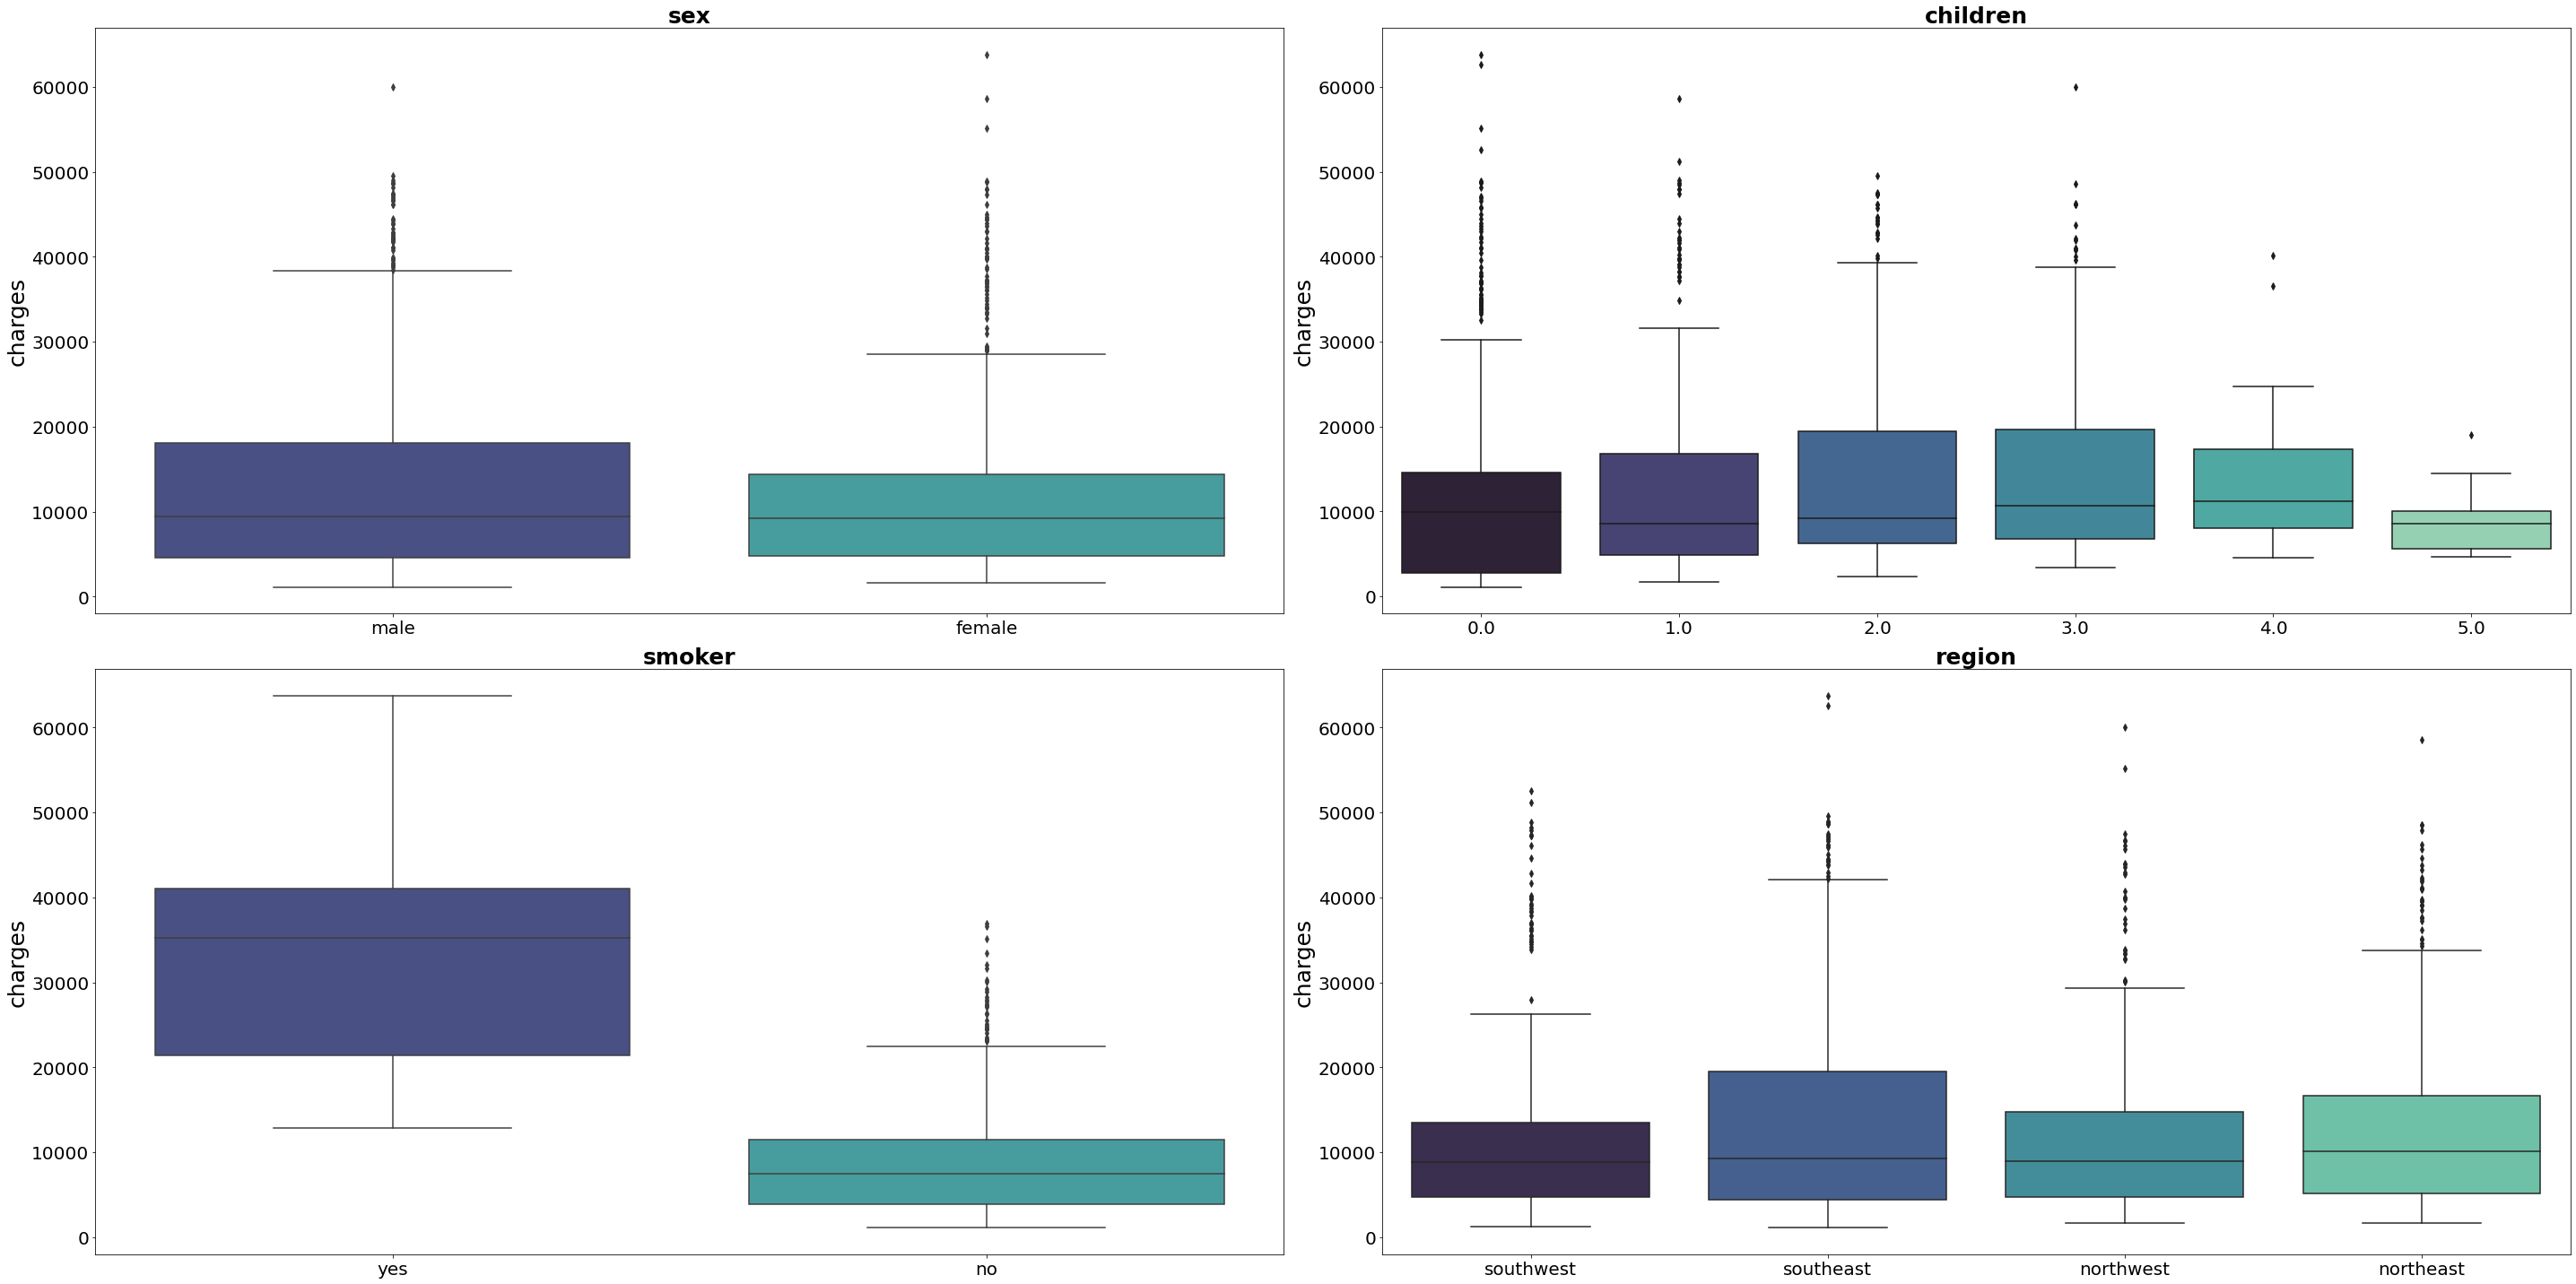

In [36]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_cat = df.select_dtypes(include = ["object", "category"]).columns

for i, colum in enumerate(columnas_cat): 
    sns.boxplot(
        data = df,
        x = colum,
        y = "charges",
        palette = "mako", 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 25, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel( "charges", fontsize = 25)


fig.tight_layout();

# Outliers

In [37]:
numericas = df.select_dtypes(include = np.number)
numericas.head()

,age,bmi,charges
0,19.0,27.900,16884.92400
1,18.0,33.770,1725.55230
2,28.0,33.000,4449.46200
3,33.0,22.705,21984.47061
4,32.0,28.880,3866.85520


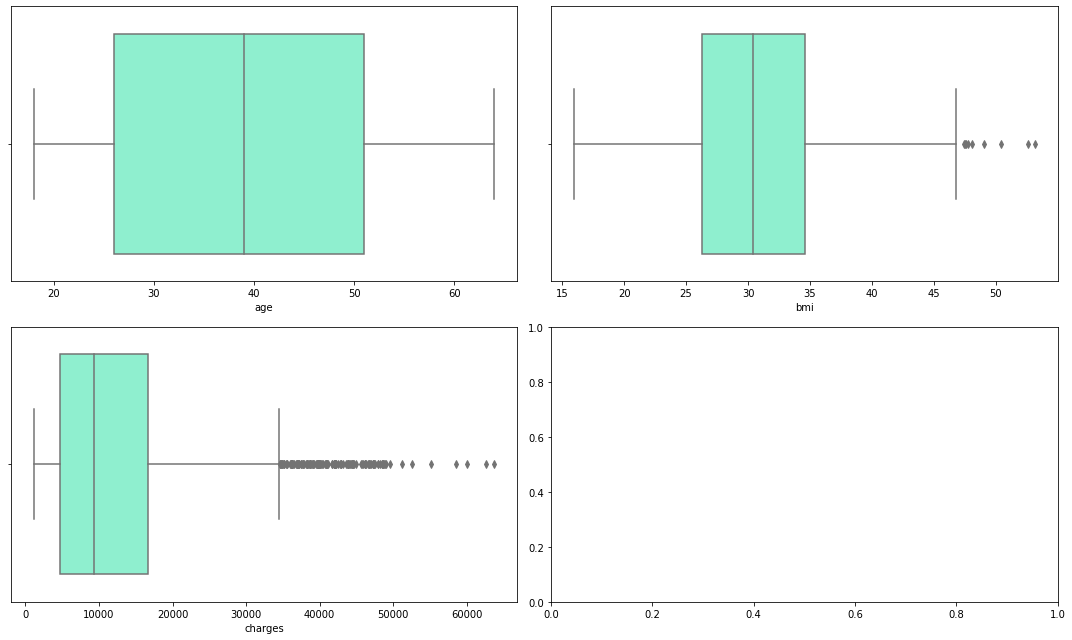

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15,9))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "aquamarine"); 

    
plt.tight_layout()
plt.show()


Llegados a este punto, vemos que tenemos muchos valores atípicos en la VR. En esta situación podríamos hacer dos cosas: 

- Seguir nuestro modelo con todos los datos

- Dividir el conjunto de datos en dos para hacer dos modelos: 

    - Un modelo para aquellos clientes por los que pagamos poco

    - Un modelo para aquellos clientes por los que pagamos mucho. 

    La pregunta en este punto es por donde dividiriamos los datos. Una buena elección es hacerlo por los cuartiles, en este caso por el cuartil 75 ya que los outliers los tenemos hacía los valores altos. 

In [39]:
# encuentra los valores correspondiente al percentil 75 con numpy 
np.percentile(df["charges"], 75)


16639.912515

In [45]:
df_menores = df[df["charges"] < np.percentile(df["charges"], 75)]
df_menores.head()

,age,sex,bmi,children,smoker,region,charges
1,18.0,male,33.77,NaN,NaN,southeast,1725.5523
2,28.0,male,33.00,3.0,no,southeast,4449.4620
4,32.0,male,28.88,0.0,no,northwest,3866.8552
5,31.0,female,25.74,0.0,no,southeast,3756.6216
6,46.0,female,33.44,1.0,no,southeast,8240.5896


<Axes: xlabel='charges', ylabel='Count'>

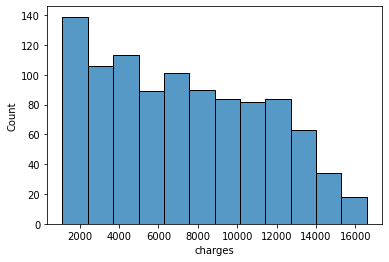

In [43]:
sns.histplot(data= df_menores, x ="charges")

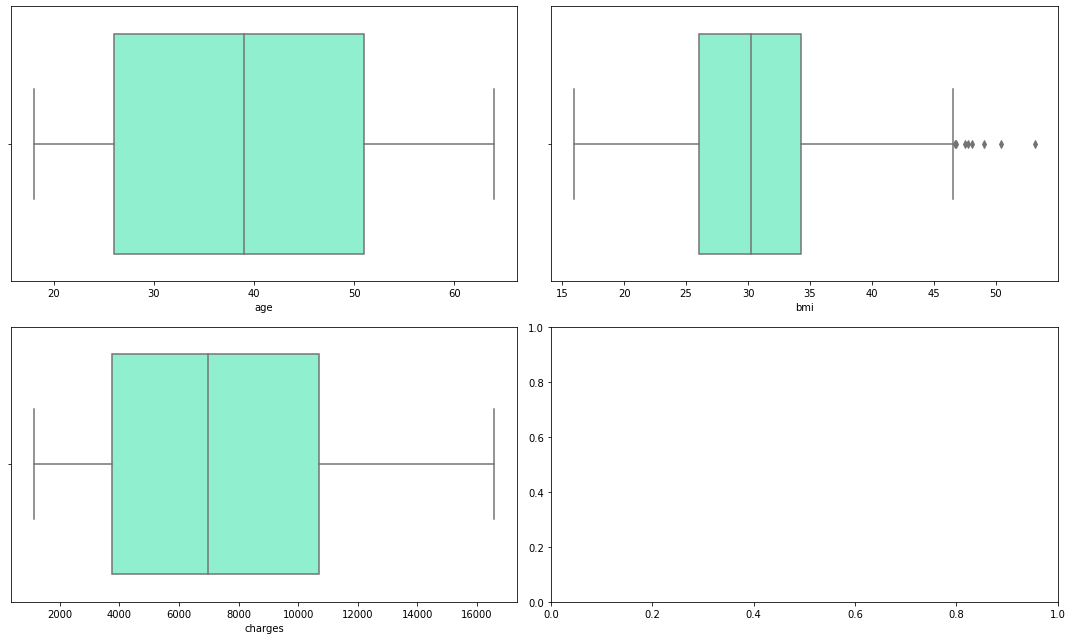

In [46]:
numericas = df_menores.select_dtypes(include = np.number)
numericas.head()
fig, axes = plt.subplots(2, 2, figsize=(15,9))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df_menores, ax=axes[indice], color = "aquamarine"); 

    
plt.tight_layout()
plt.show()

In [47]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [48]:
lista_columnas = list(numericas.columns)
ind = detectar_outliers(lista_columnas, df_menores)
ind

{'bmi': [116, 286, 401, 847, 1088, 1317]}

Al ser pocos, podemos optar por no gestionar estos outliers, pero tenemos que tenerlo en cuenta de cara al futuro, a la hora de hacer la estandarización de las VP. Recordemos que en estos casos, es recomendable usar el RobustScaler. 

CUIDADO! HEMOS CAMBIADO EL CONJUNTO DE DATOS, POR LO QUE VAMOS A VOLVER A HACER LAS GRÁFICAS DE EXPLORACIÓN PARA VER SI HA CAMBIADO ALGO

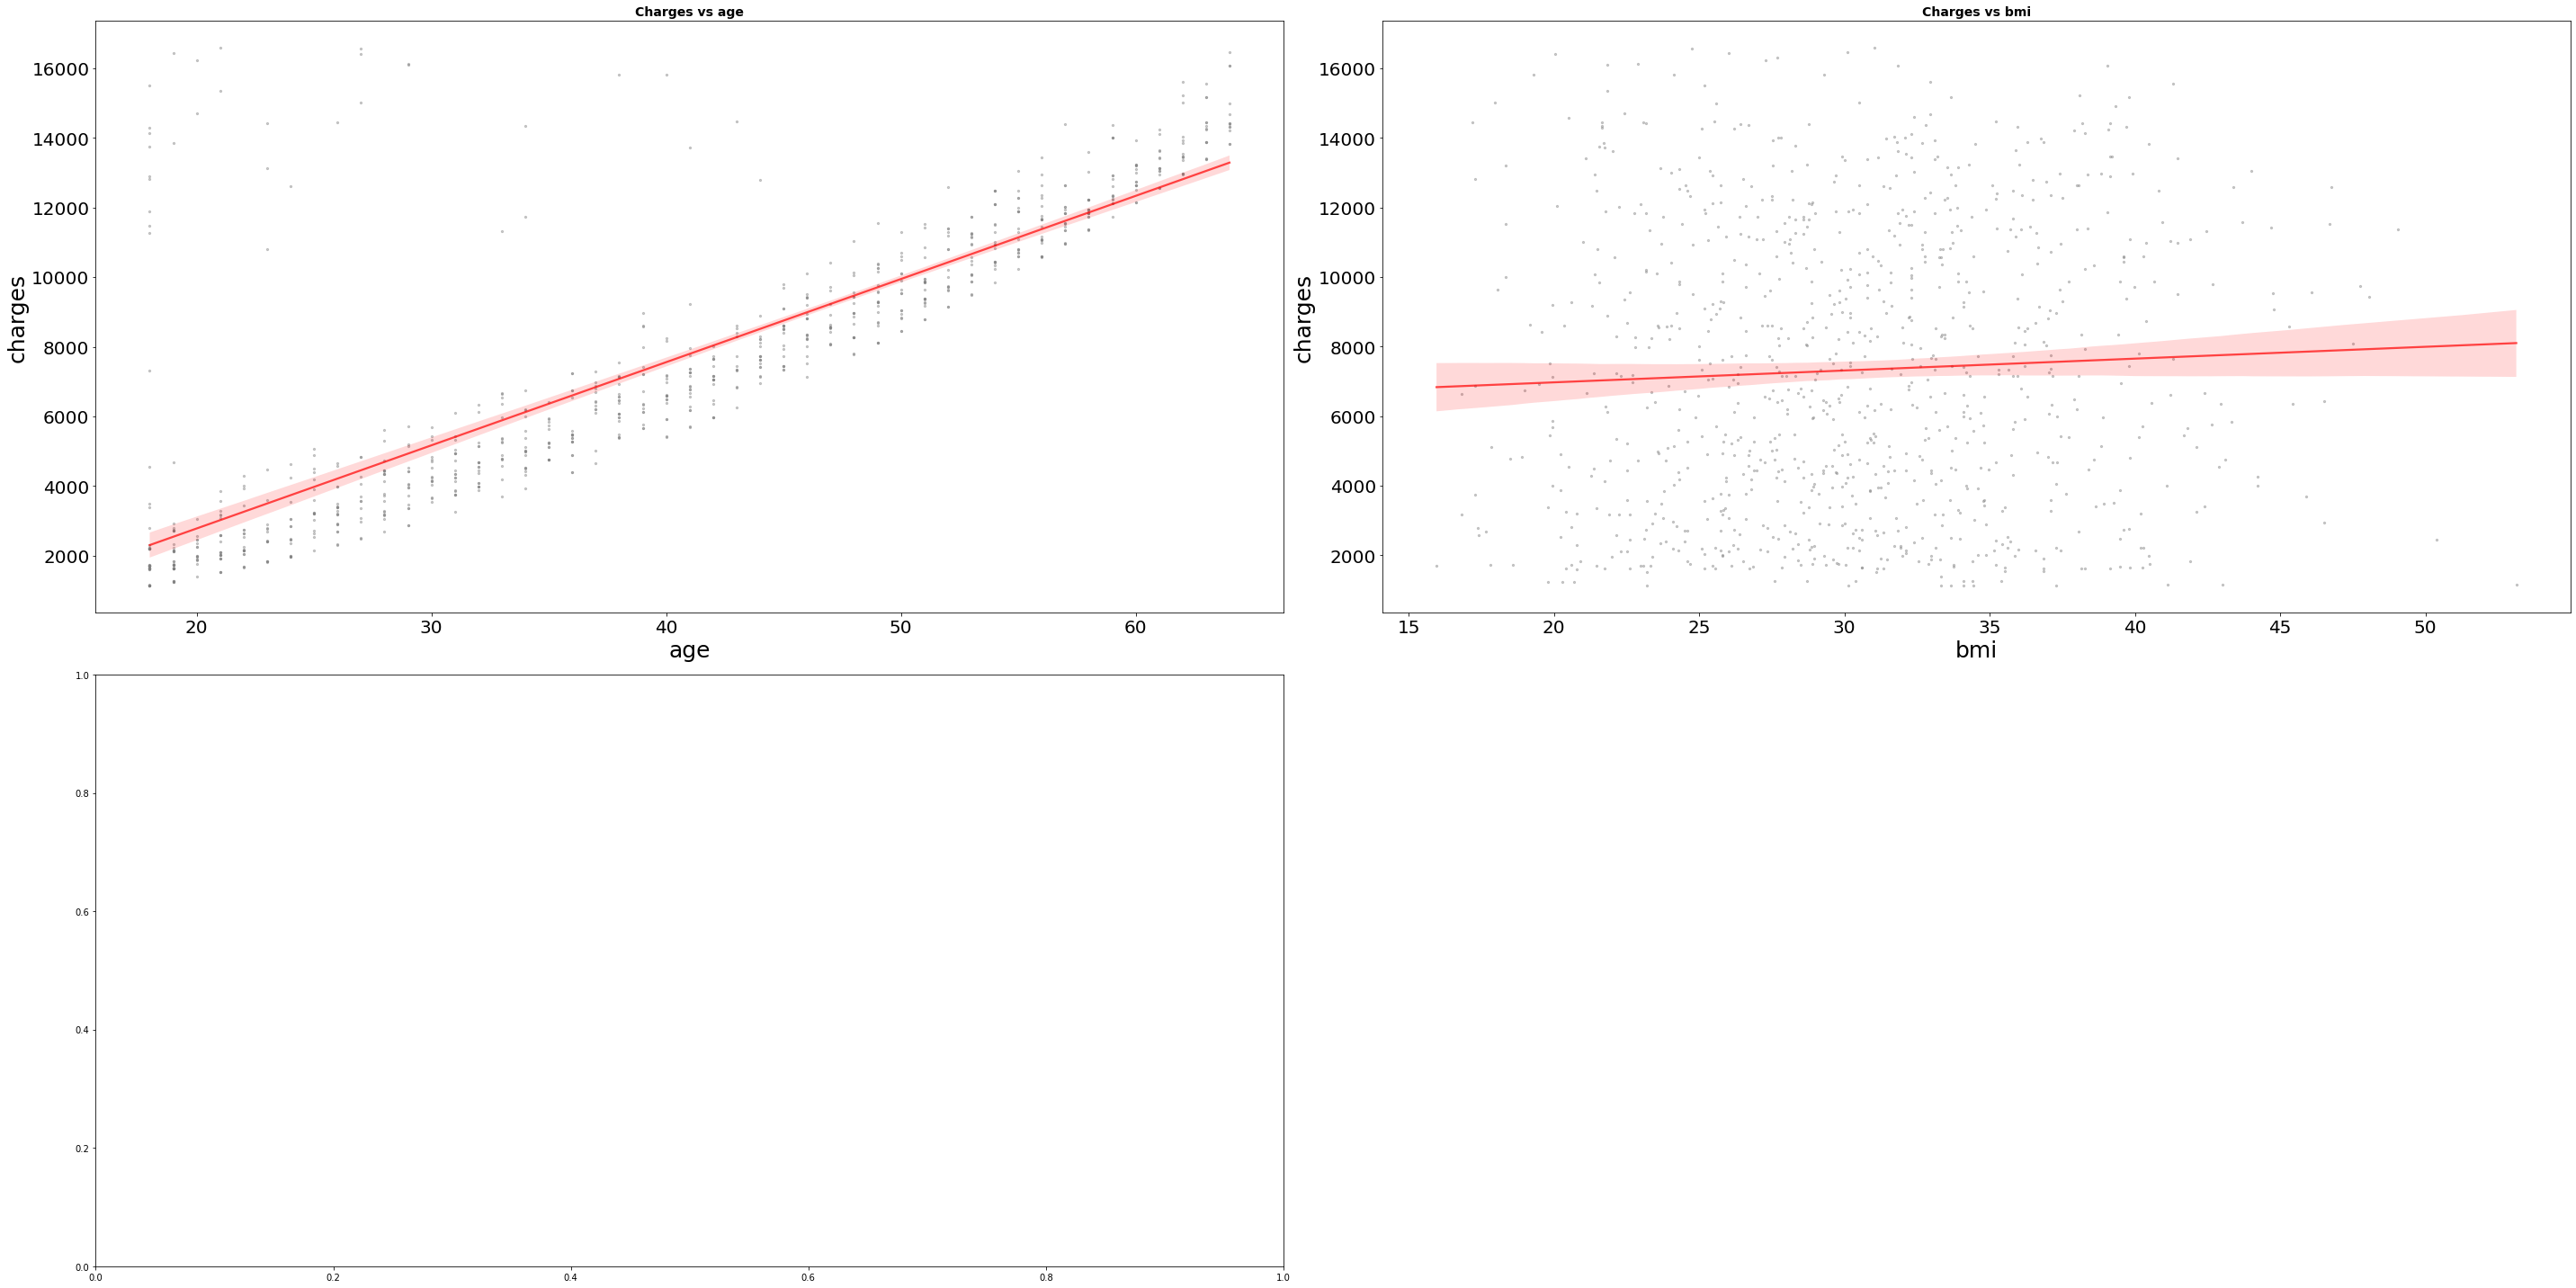

In [51]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_numeric = df_menores.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df_menores[colum], 
        y = df_menores["charges"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4, "s":20 }, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Charges vs {colum}", fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum, fontsize = 25)
    axes[i].set_ylabel( "charges", fontsize = 25)
    
fig.tight_layout()
fig.delaxes(axes[-1]);

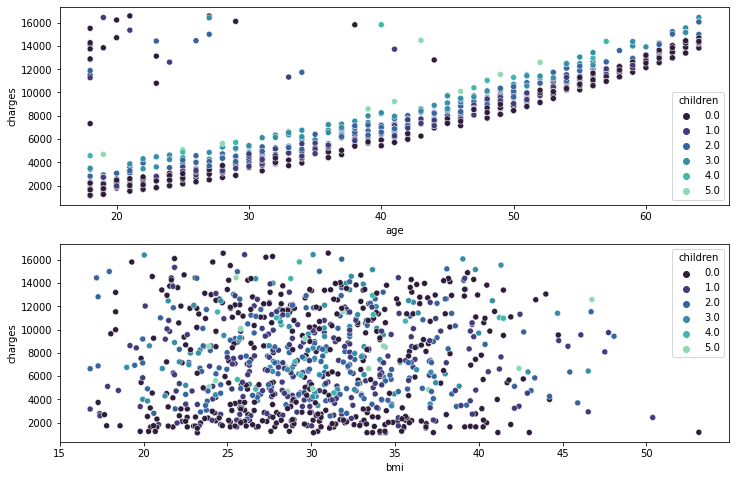

In [52]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8))
sns.scatterplot(x = "age", y = "charges", hue = "children", data = df_menores, palette="mako", ax = axes[0])
sns.scatterplot(x = "bmi", y = "charges", hue = "children", data = df_menores, palette="mako", ax = axes[1]);

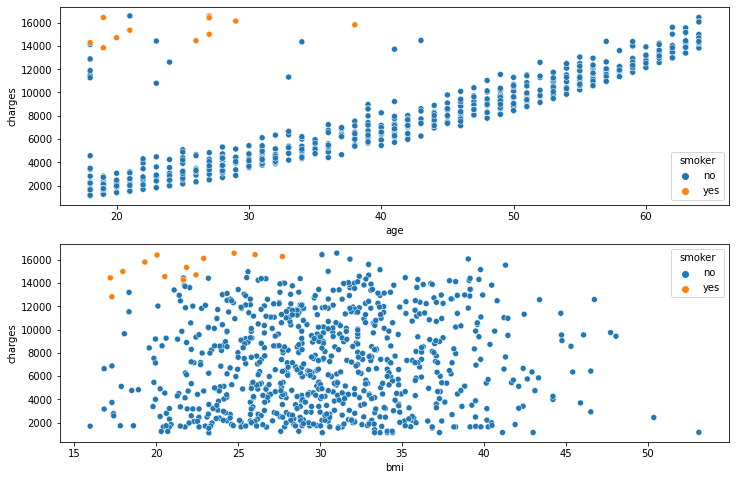

In [54]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8))
sns.scatterplot(x = "age", y = "charges", hue = "smoker", data = df_menores, ax = axes[0])
sns.scatterplot(x = "bmi", y = "charges", hue = "smoker", data = df_menores, ax = axes[1]);

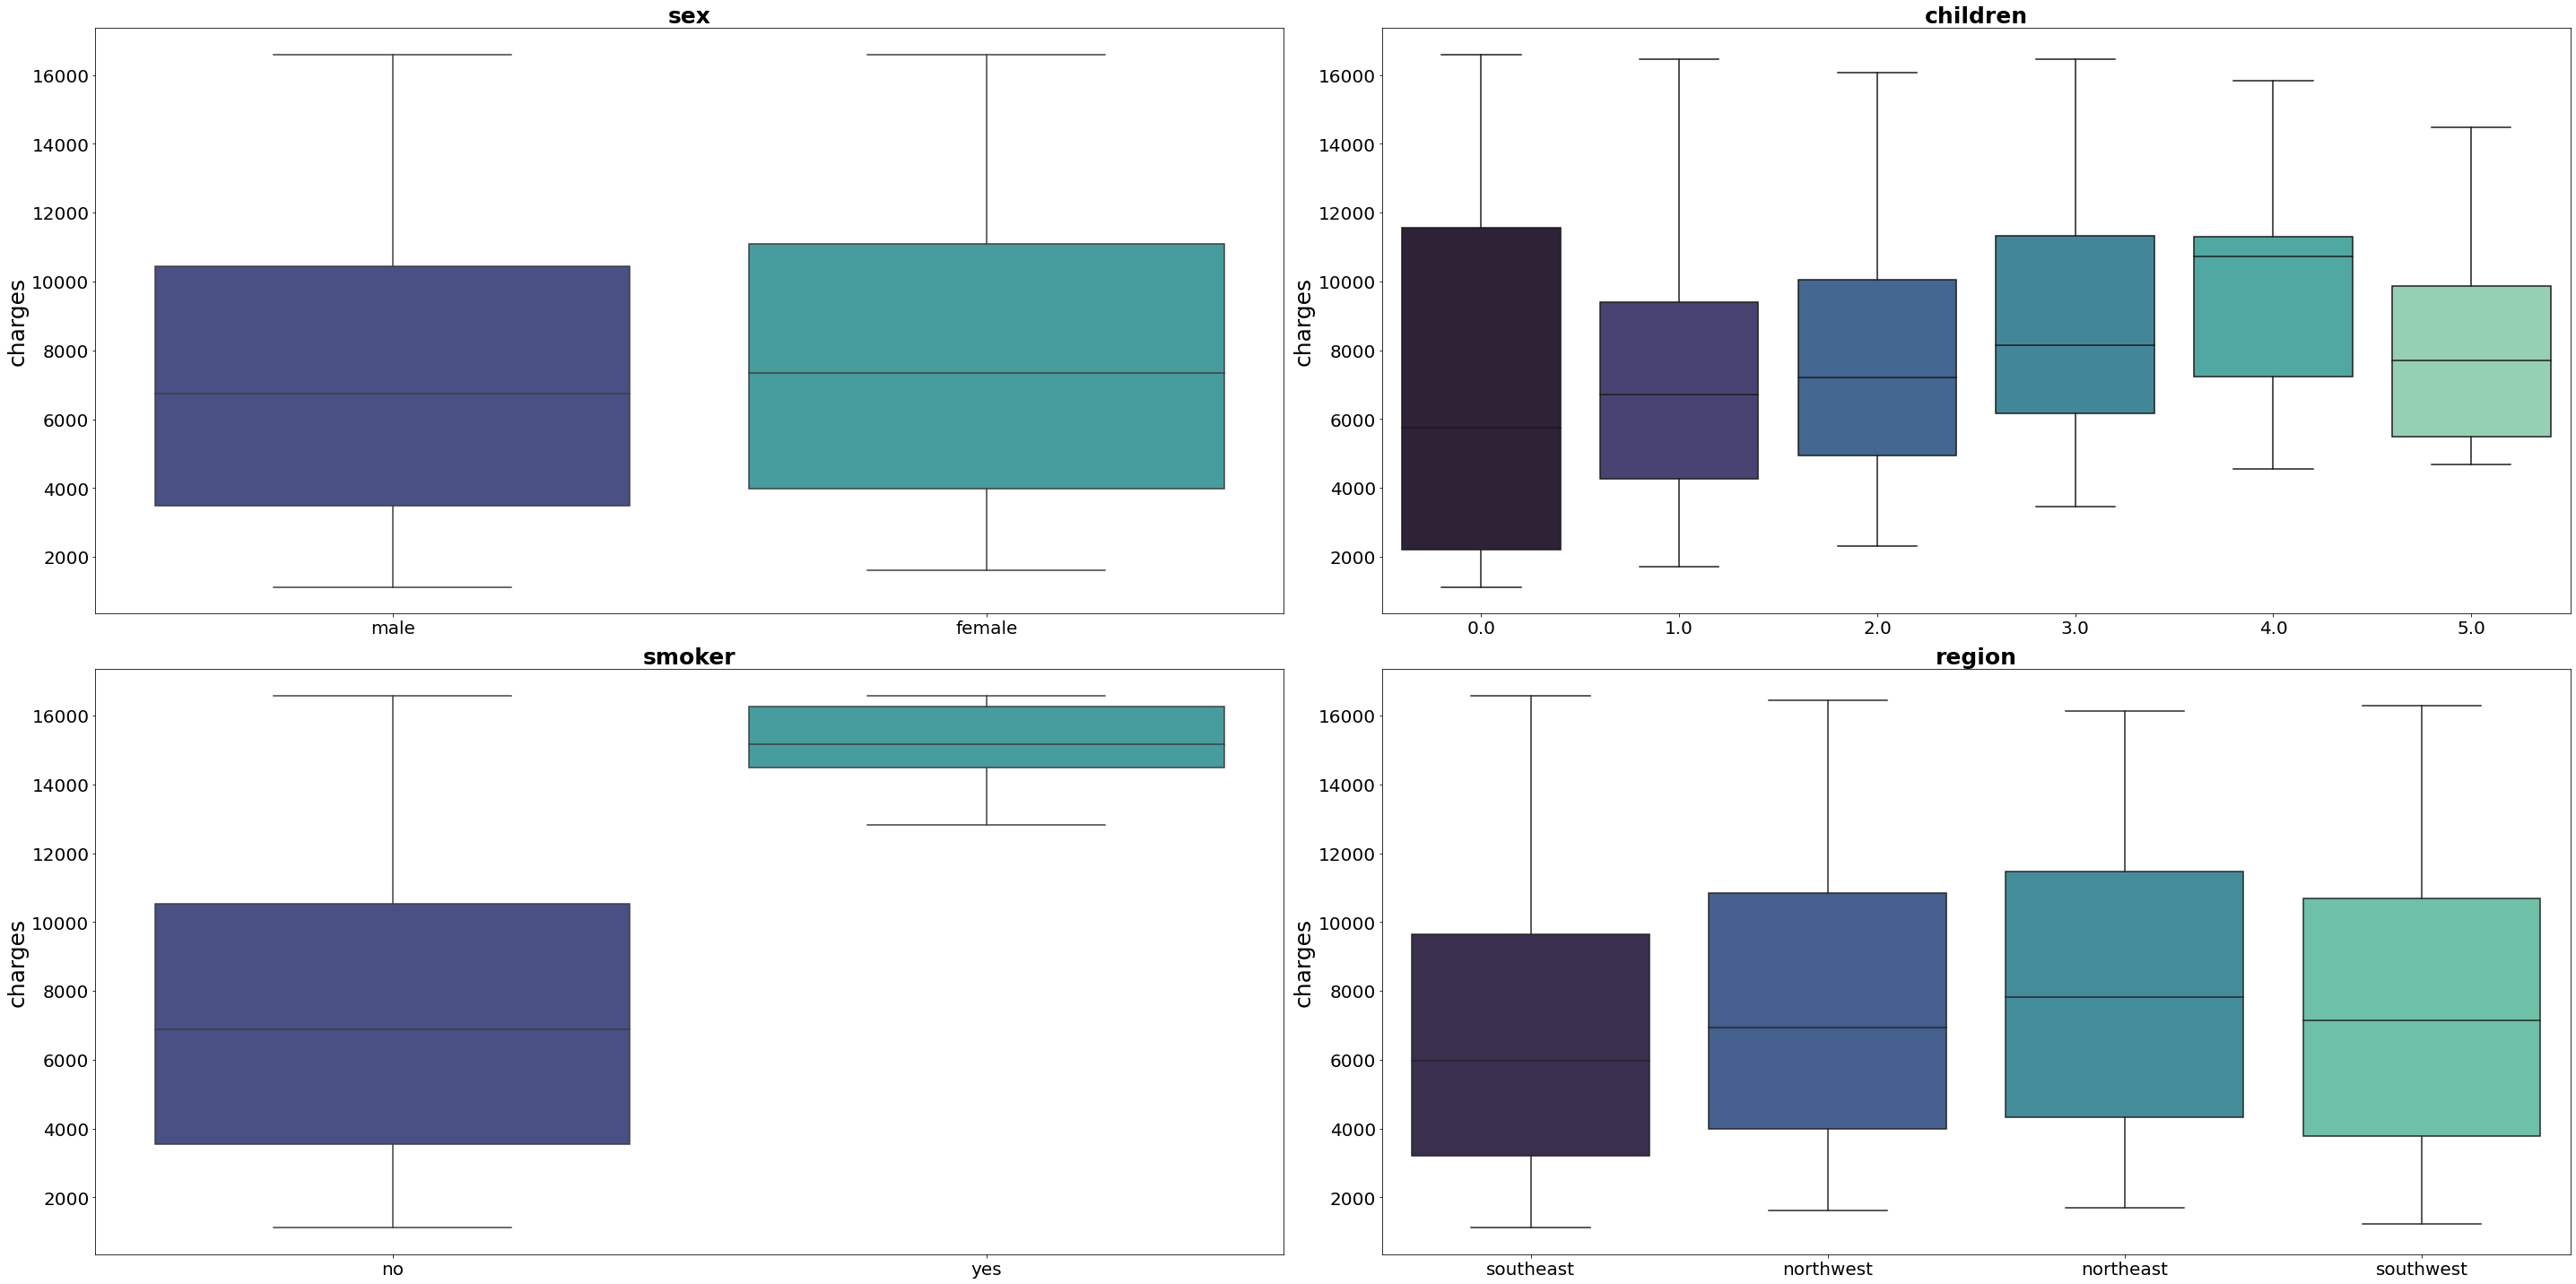

In [55]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_cat = df_menores.select_dtypes(include = ["object", "category"]).columns

for i, colum in enumerate(columnas_cat): 
    sns.boxplot(
        data = df_menores,
        x = colum,
        y = "charges",
        palette = "mako", 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 25, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel( "charges", fontsize = 25)


fig.tight_layout();